In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import yaml
from models.bendr import EncoderConv, ContextNetwork
import torch
import yaml
import numpy as np

with open('configs/cluster_config_bendr.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

encoder_sd = torch.load('/home/ps5359/checkpoints/encoder_2024-10-08T00:17:31.296499.pt', map_location=torch.device('cpu') )
context_network_sd = torch.load('/home/ps5359/checkpoints/context_network_2024-10-08T00:17:31.296499.pt', map_location=torch.device('cpu') )


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [4]:
from dataset.labeled_dataset import EEGLabeledDataset

dataset = EEGLabeledDataset(
    data_path='/home/ps5359/data/1k/h5',
    cache_processed_path='/vast/ps5359/test_cache_1k/cache/',
    train_length=73728, dataset_mode="full",
    rebuild_cache=False, limit=3200,
    target_config={
    "user_id": False,
    "activity": False, },
    clipped_threshold=0.3 
)
dataset[0]


{'data': tensor([[ 0.3447,  0.2040,  0.5195,  ..., -0.0837,  0.2554,  0.3601],
         [ 0.0632, -0.2244, -0.0534,  ..., -0.6966, -0.2070,  0.1250],
         [ 0.6539,  0.1159,  0.1123,  ..., -0.7902, -0.4160, -0.3334],
         [ 0.8126,  0.2253,  0.2093,  ..., -0.4916, -0.0486,  0.1091]])}

In [5]:
from models.bendr import calc_loss_proper

batch = {}
batch['data'] = torch.stack([dataset[0]['data'] for i in range(8)], 0)
batch = encoder(batch)
batch = context_network(batch)
batch = calc_loss_proper(batch, 0.1, 80)

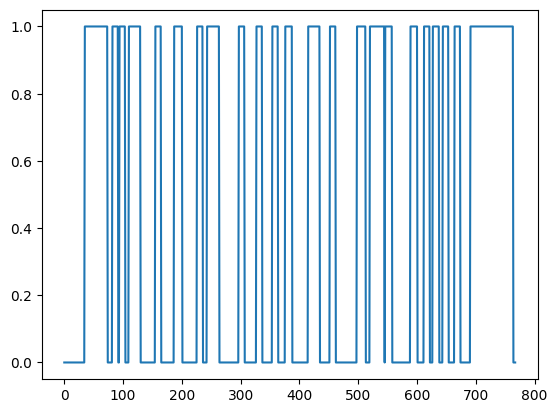

In [7]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(768), batch['mask'][1])

In [16]:
(batch['mask'][0] * 1).sum()

tensor(384)

In [18]:
(131 + 54) / 384

0.4817708333333333

In [ ]:
per_masktoken_loss

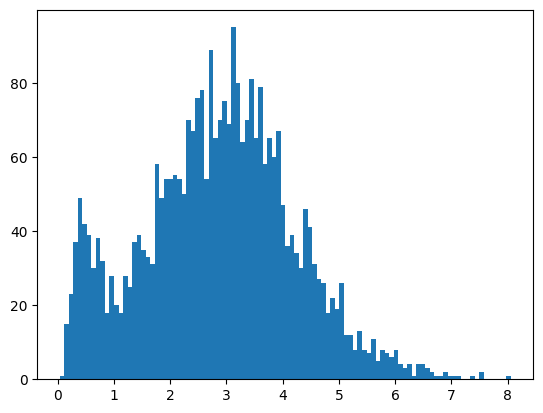

In [11]:
plt.hist(batch['per_masktoken_loss'].flatten().detach(), bins=100)
None

In [13]:
masktoken_index

tensor([[  0,   7],
        [  0,   8],
        [  0,   9],
        ...,
        [  7, 765],
        [  7, 766],
        [  7, 767]])

In [41]:
masktoken_index = (batch['mask'] * 1).nonzero()
masktoken_index = masktoken_index[:, 1].view(8, 384)

assert batch['mask'][0, masktoken_index[0, :]].all()

(0.0, 300.0)

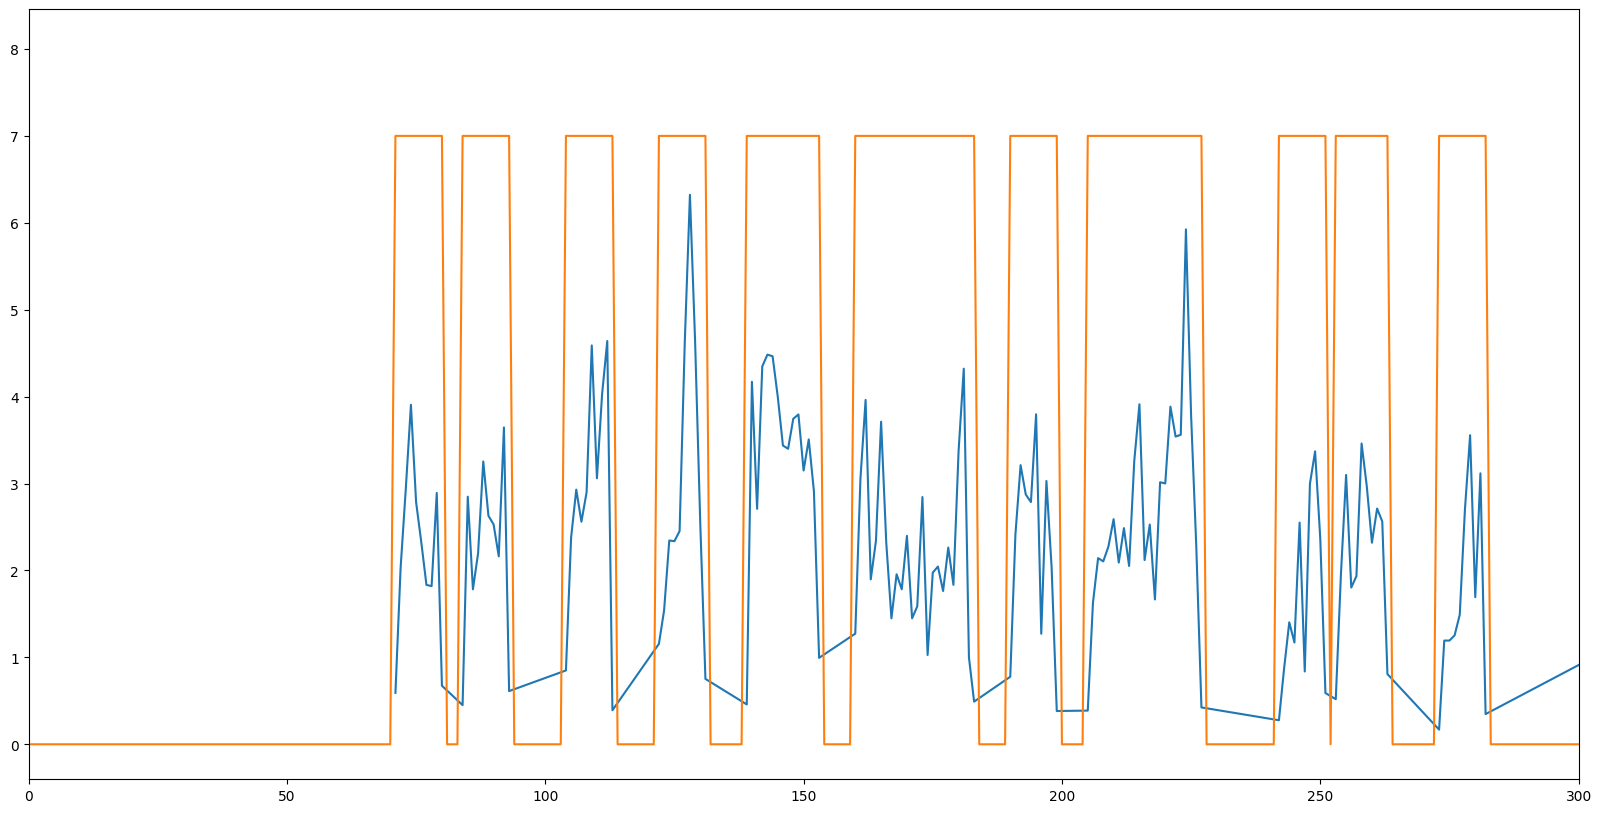

In [51]:
plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(masktoken_index[2], batch['per_masktoken_loss'][2].detach())
plt.plot(torch.arange(768), batch['mask'][2] * 7)
plt.xlim(0, 300) 

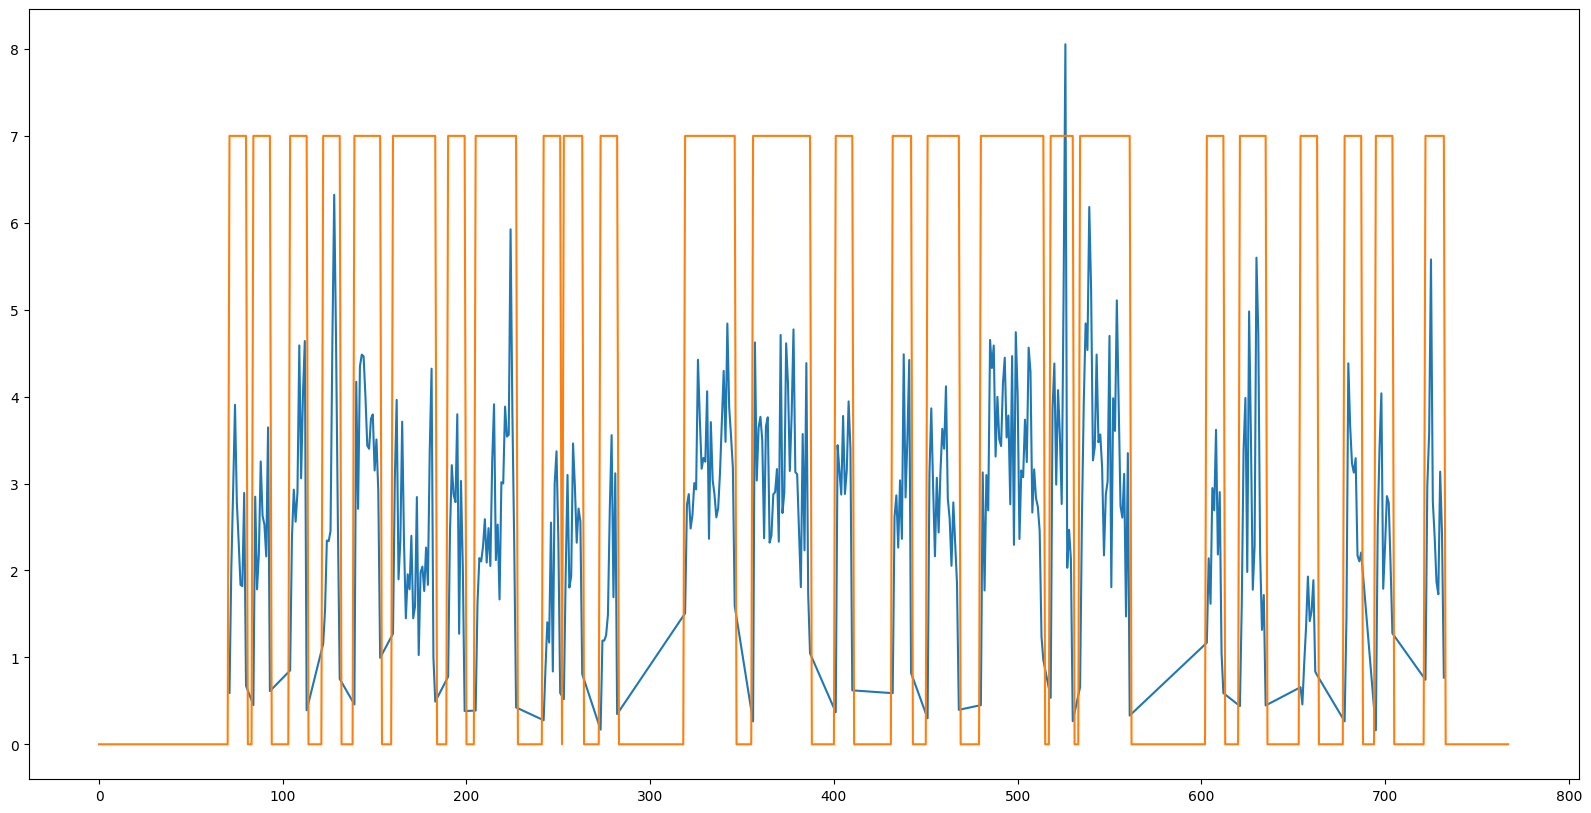

In [52]:
plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(masktoken_index[2], batch['per_masktoken_loss'][2].detach())
plt.plot(torch.arange(768), batch['mask'][2] * 7)


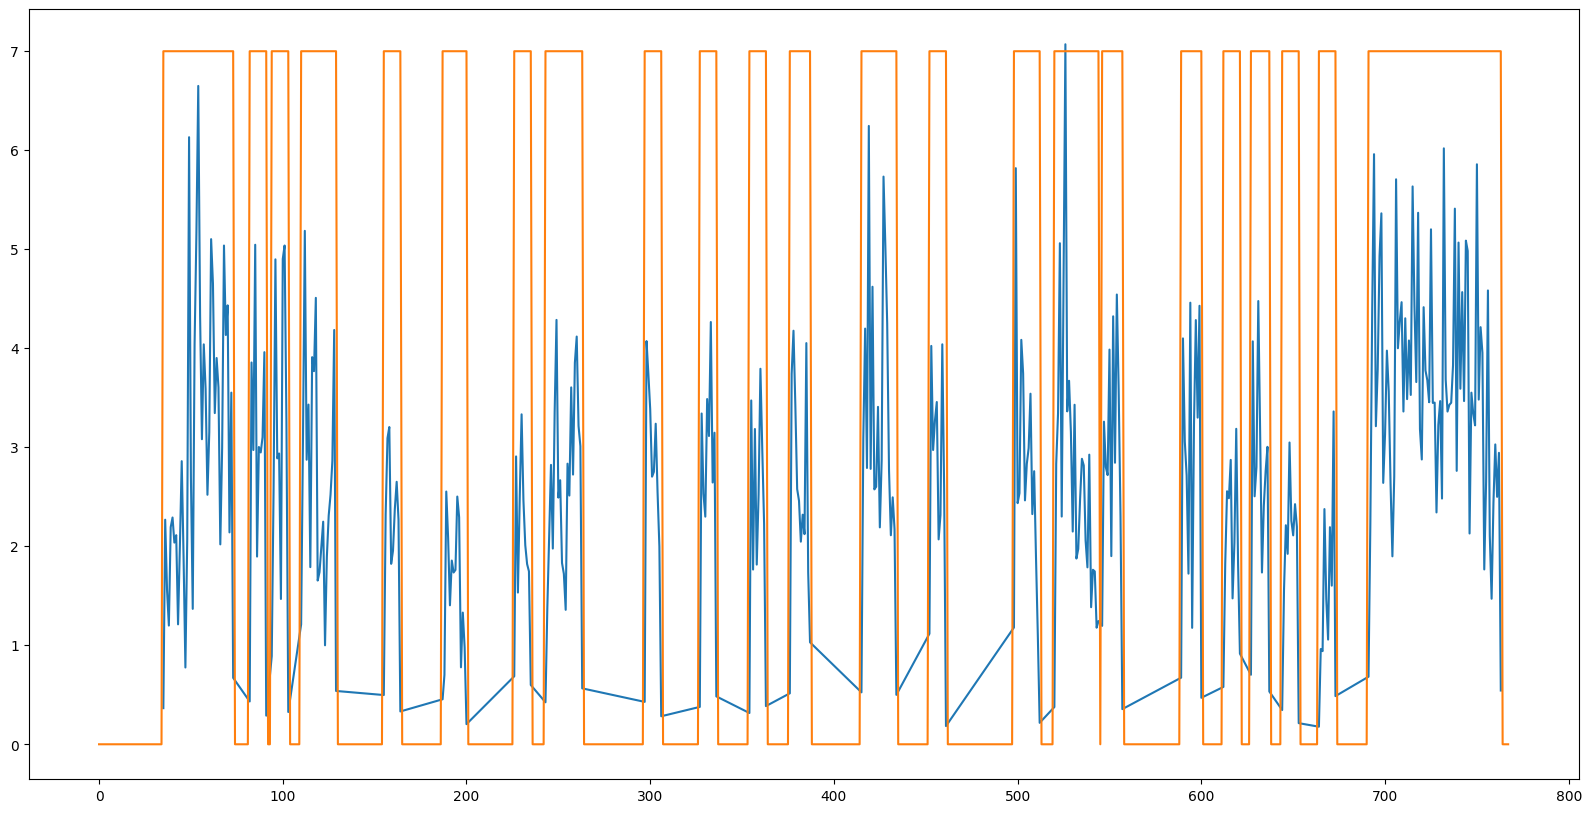

In [54]:
plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(masktoken_index[1], batch['per_masktoken_loss'][1].detach())
plt.plot(torch.arange(768), batch['mask'][1] * 7)


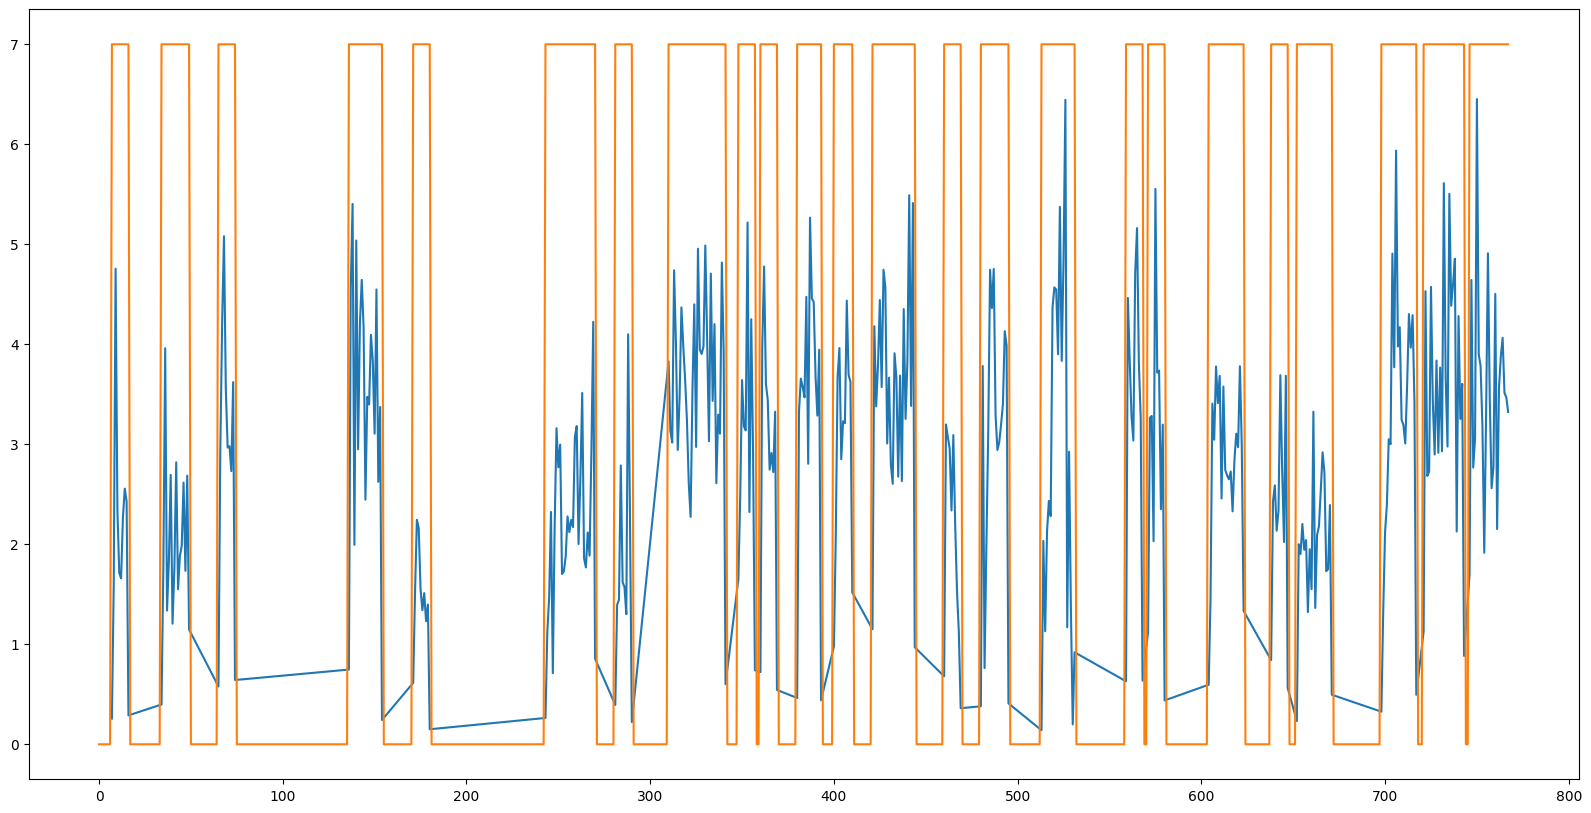

In [56]:
plt.rcParams["figure.figsize"] = (20, 10)

plt.plot(masktoken_index[0], batch['per_masktoken_loss'][0].detach())
plt.plot(torch.arange(768), batch['mask'][0] * 7)


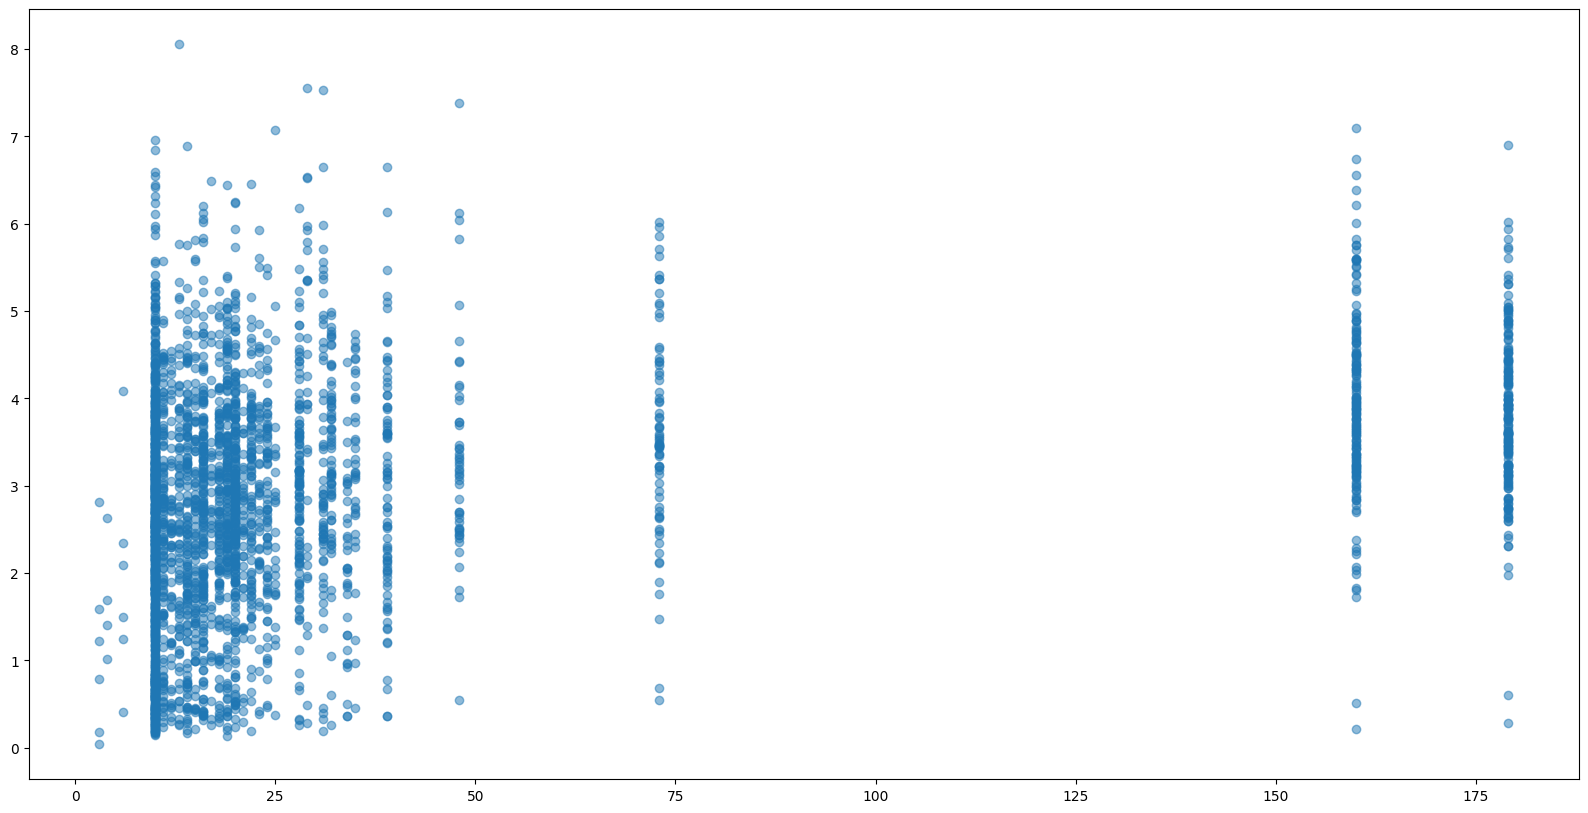

In [92]:
def count_consecutive_trues(bool_tensor):
    # Initialize an output tensor of the same shape filled with zeros
    output_tensor = torch.zeros_like(bool_tensor, dtype=torch.int32)
    
    count = 0
    for i in range(len(bool_tensor)):
        if bool_tensor[i]:  # If the current element is True
            count += 1
            output_tensor[i] += count  # Assign count to the current position
        else:
            count = 0  # Reset count when False is encountered
    
    count = 0
    for i in range(len(bool_tensor) - 1, -1, -1):
        if bool_tensor[i]:  # If the current element is True
            count += 1
            output_tensor[i] += count  # Assign count to the current position
        else:
            count = 0  # Reset count when False is encountered
    
    return output_tensor - 1 * (output_tensor > 0)

cm = torch.stack([count_consecutive_trues(batch['mask'][i]) for i in range(8)], 0)

plt.scatter(cm[batch['mask']].detach(), batch['per_masktoken_loss'].detach(), alpha=0.5)
# plt.xlim(0, 40)


(0.0, 40.0)

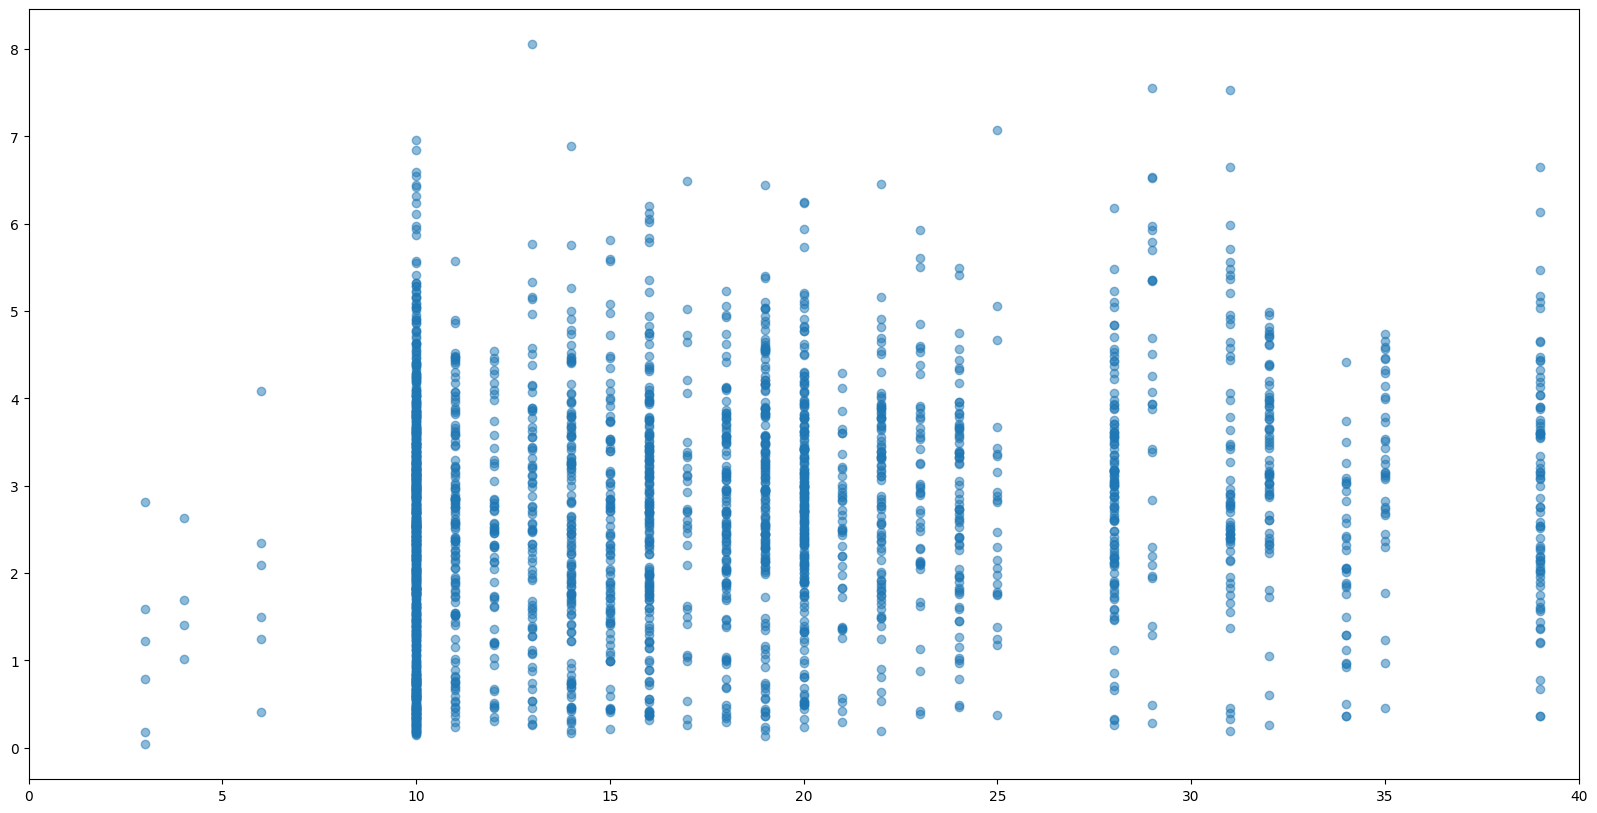

In [93]:
plt.scatter(cm[batch['mask']].detach(), batch['per_masktoken_loss'].detach(), alpha=0.5)
plt.xlim(0, 40)

In [81]:
batch['per_masktoken_loss'].detach().flatten()[:10] == batch['per_masktoken_loss'][0, :10]

tensor([True, True, True, True, True, True, True, True, True, True])

<Axes: xlabel='None', ylabel='None'>

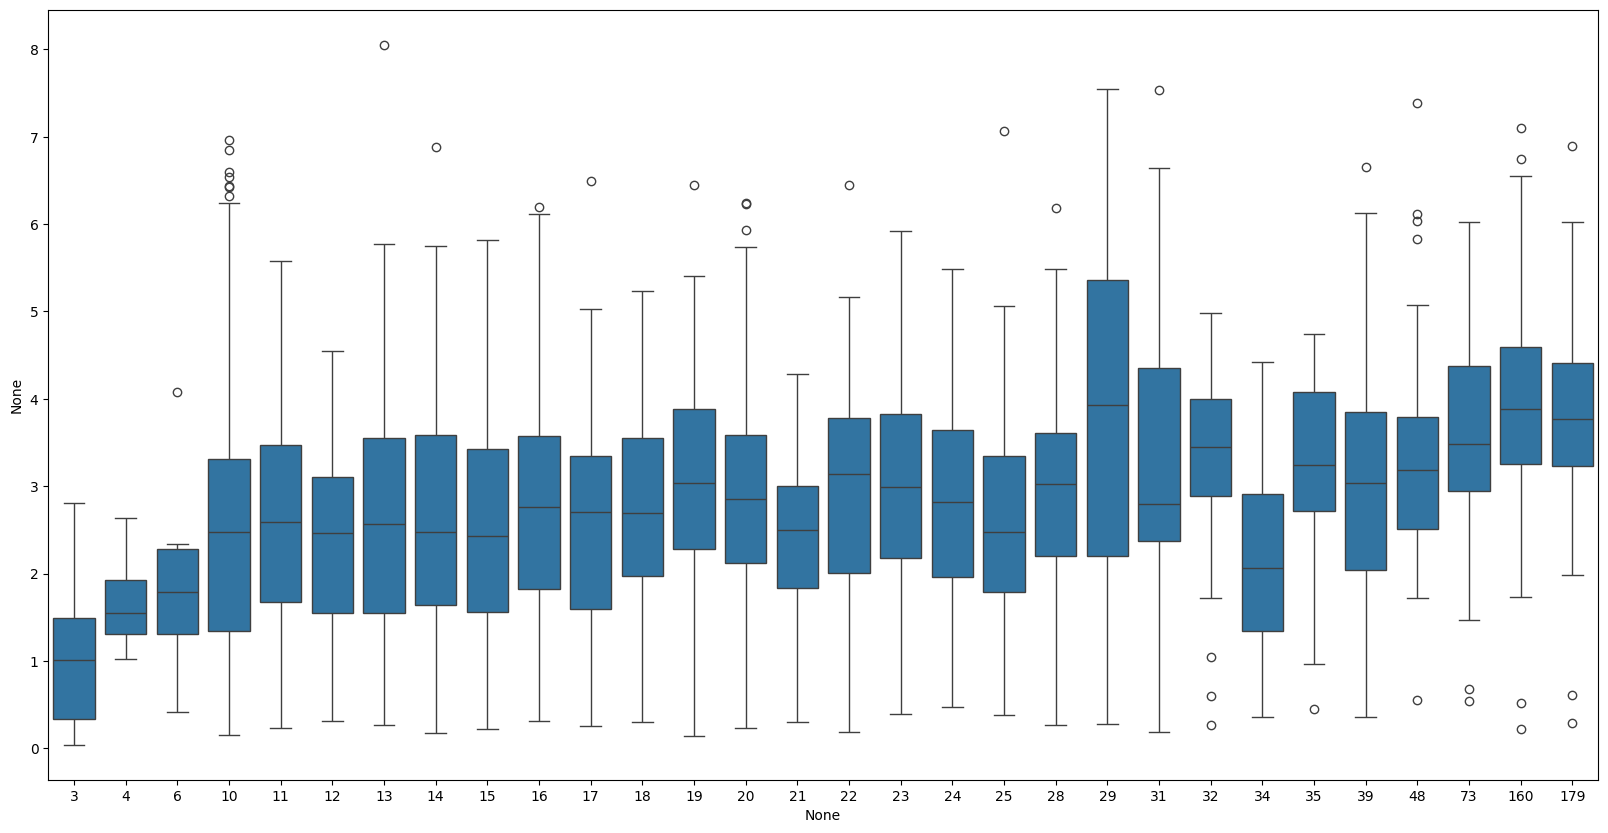

In [86]:
import seaborn as sns

sns.boxplot(x=cm[batch['mask']].detach(), y=batch['per_masktoken_loss'].detach().flatten())

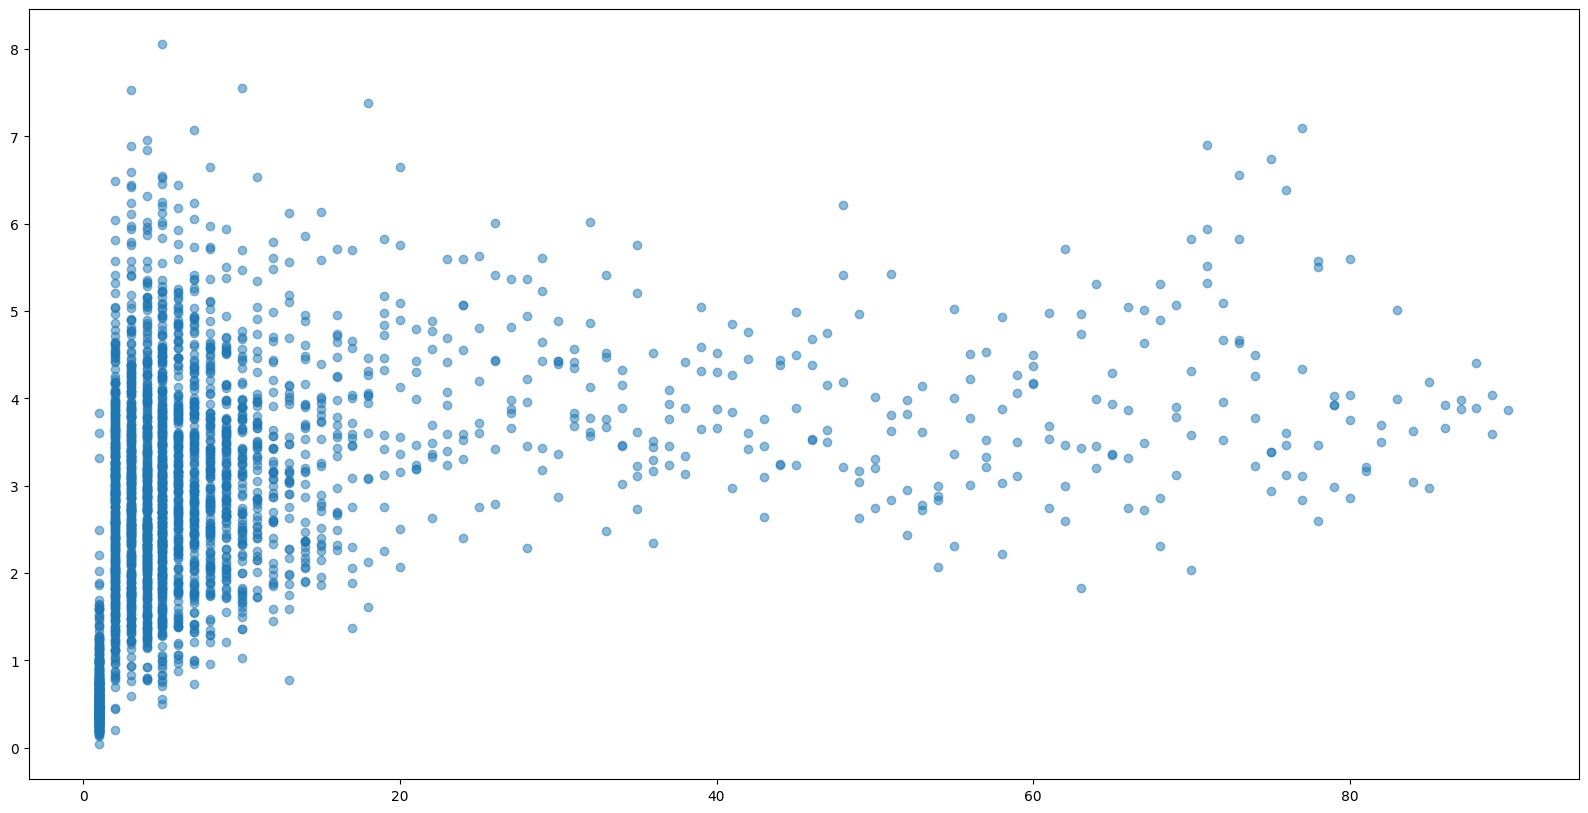

In [91]:
def distance_edge(bool_tensor):
    # Initialize an output tensor of the same shape filled with zeros
    out1 = torch.zeros_like(bool_tensor, dtype=torch.int32)
    out2 = torch.zeros_like(bool_tensor, dtype=torch.int32)
    
    count = 0
    for i in range(len(bool_tensor)):
        if bool_tensor[i]:  
            count += 1
            out1[i] += count  
        else:
            count = 0  
    
    count = 0
    for i in range(len(bool_tensor) - 1, -1, -1):
        if bool_tensor[i]: 
            count += 1
            out2[i] += count 
        else:
            count = 0 
    
    return torch.minimum(out1, out2)

cm = torch.stack([distance_edge(batch['mask'][i]) for i in range(8)], 0)

plt.scatter(cm[batch['mask']].detach(), batch['per_masktoken_loss'].detach(), alpha=0.5)
plt.xlim(0, 40)


(0.0, 20.0)

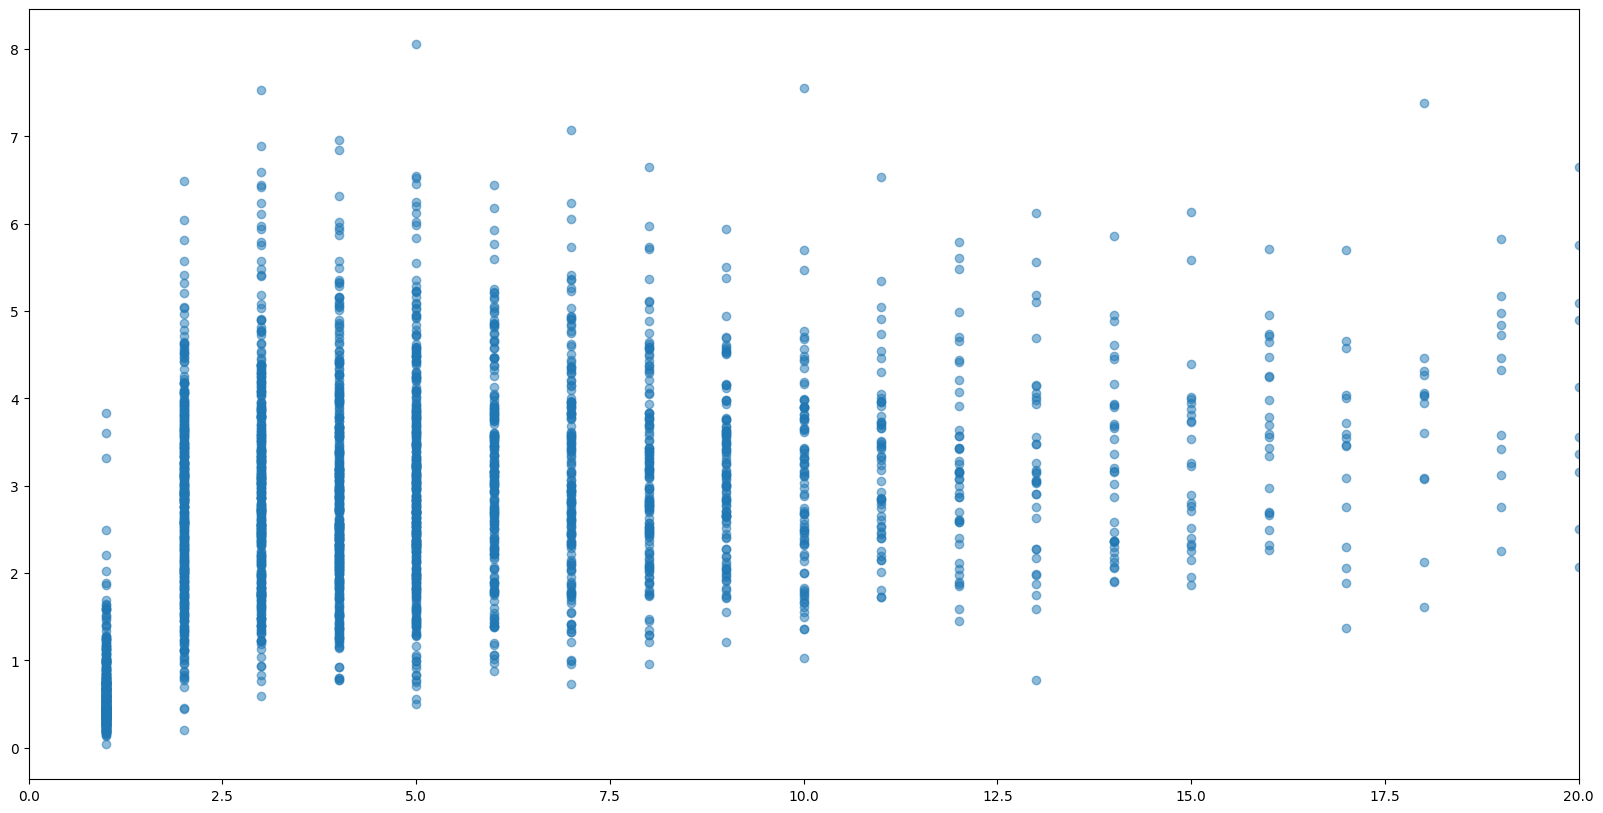

In [94]:
plt.scatter(ds[batch['mask']].detach(), batch['per_masktoken_loss'].detach(), alpha=0.5)
plt.xlim(0, 20)

(-0.5, 20.5)

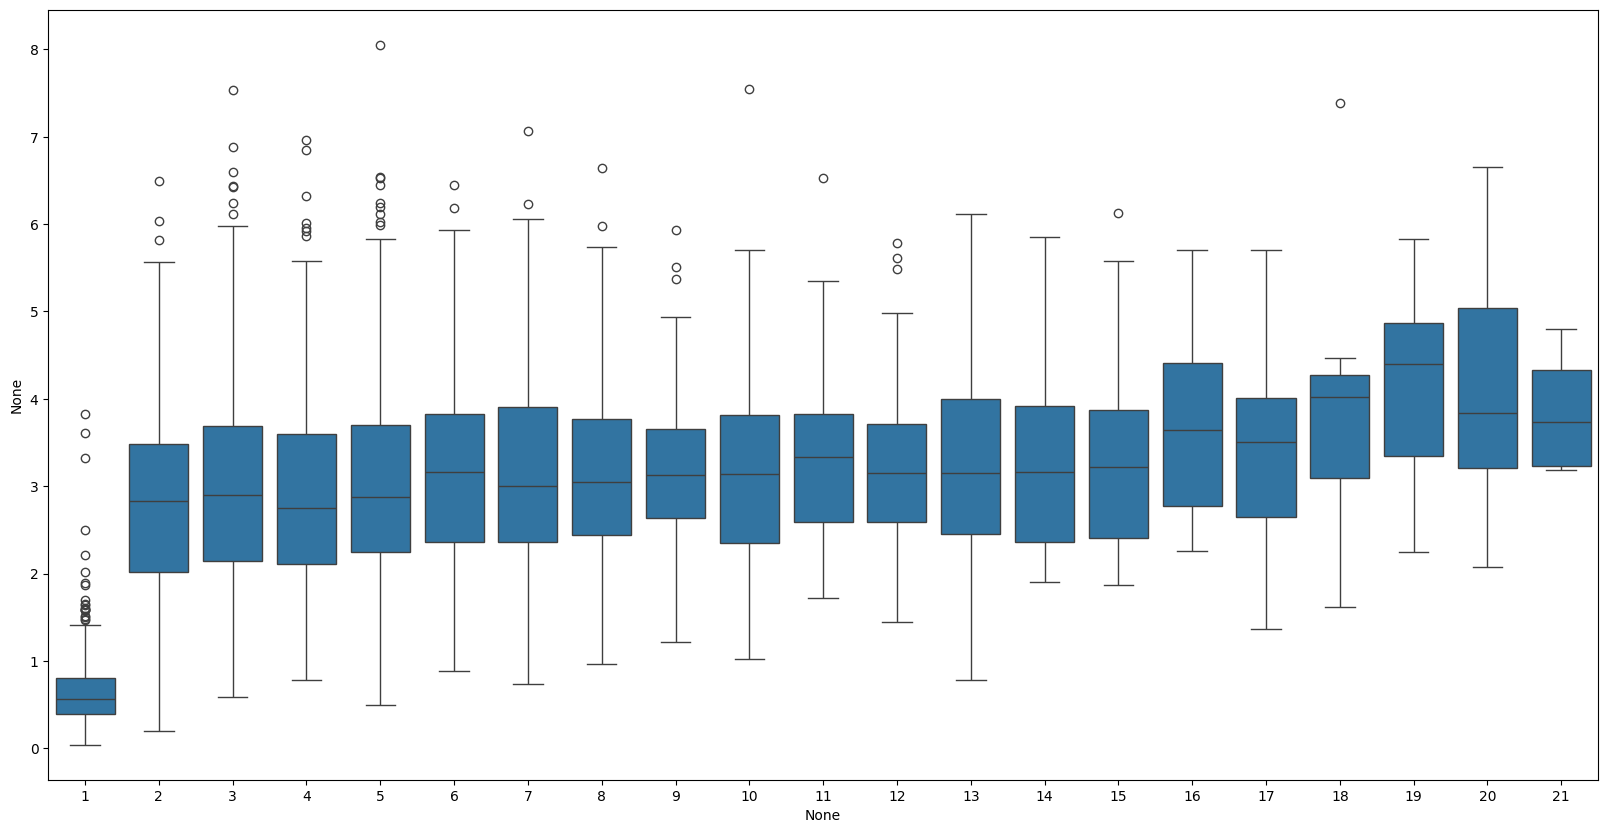

In [98]:
sns.boxplot(x=ds[batch['mask']].detach(), y=batch['per_masktoken_loss'].detach().flatten())
plt.xlim(-0.5, 20.5)